In [1]:
import numpy as np
import random
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

In [4]:
def sampleChania(Chania, n_points):
    data = Chania[:,0:8]
    np.random.seed(0)
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

## Read dataset

In [5]:
Chania = np.genfromtxt('processedChania.csv', delimiter=',')

## Privitizer and Adversary

In [477]:
def privatizer(x):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):
        l1 = tf.layers.dense(x, 8, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, x.shape[1].value)
    return l2


def adversary(y):
    with tf.variable_scope("ad", reuse=tf.AUTO_REUSE):
        l1 = tf.layers.dense(y, 16, activation=tf.nn.relu)
        # num users = 5
        l2 = tf.layers.dense(l1, 5, activation=tf.nn.softmax)
    return l2

## Signal Map Error

In [346]:
def signal_map_error(x, y):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):

        # build model from input
        inputmodel = keras.Sequential([
            keras.layers.Dense(10, input_shape=(2, ), activation=tf.nn.relu),
            keras.layers.Dense(10, activation=tf.nn.relu),
            keras.layers.Dense(1)        
        ])
        optimizer = tf.train.FtrlOptimizer(0.001)
        inputmodel.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        inputmodel.fit(x[:,2:], x[:,1], steps_per_epoch=1, epochs=100, verbose=0)   

        # build model from output
        outputmodel = keras.Sequential([
            keras.layers.Dense(10, input_shape=(2, ), activation=tf.nn.relu),
            keras.layers.Dense(10, activation=tf.nn.relu),
            keras.layers.Dense(1)        
        ])
        outputmodel.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
        outputmodel.fit(y[:,2:], y[:,1], steps_per_epoch=1, epochs=100, verbose=0)  
        
        # compare inputmodel(input) and outputmodel(input)
        # map_error = tf.reduce_mean(tf.squared_difference(inputmodel(x[:,2:]), outputmodel(x[:,2:])))
        
        # compare inputmodel(testpoints) and outputmodel(testpoints)
        testpoints = np.mgrid[-1:1:15j, -1:1:15j].reshape(2,-1).T
        grid = tf.constant(testpoints, dtype=tf.float32)
        map_error = tf.reduce_mean(tf.squared_difference(inputmodel(grid), outputmodel(grid)))

    return map_error, inputmodel, outputmodel

## Classification Error

In [323]:
def classification_error(z, trueusers):
    with tf.variable_scope("ad", reuse=tf.AUTO_REUSE):
        class_error = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, z))
    return class_error

## Privatizer Loss

In [324]:
def privatizer_loss(x, y, trueusers, threshold):
    with tf.variable_scope("priv", reuse=tf.AUTO_REUSE):
        penalty = 2
        
        c_e = classification_error(z, trueusers)
        s_m_e, _, _ = signal_map_error(x, y)
        
        zero = tf.constant(0, dtype=tf.float32)
        loss = -1*c_e + penalty*tf.math.maximum(zero, threshold-s_m_e)
        
    return loss        

## GAP

In [325]:
# initialize privatizer and adversary
# for i in range(n):
#     choose sample points
#     y = privatizer(x)
#     z = adversary(y)
#     for k in range(100):
#         train adversary
#     train privatizer

In [326]:
# initialize 
threshold = tf.constant(0.5, dtype=tf.float32)
x, trueusers = sampleChania(Chania, n_points=100)
y = privatizer(x)
z = adversary(y)
n = 1

# initialize loss variables
class_error = classification_error(z, trueusers)
priv_loss = privatizer_loss(x, y, trueusers, threshold)

# initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(n):

    # sample points
    x, trueusers = sampleChania(Chania, n_points=100)
    
    # run data through privatizer
    y = privatizer(x)
    
    # run data through adversary
    z = adversary(y)

    ad_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="ad")
    ad_train = tf.train.GradientDescentOptimizer(0.01).minimize(class_error, var_list = ad_vars)
    
    priv_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="priv")
    priv_train = tf.train.GradientDescentOptimizer(0.01).minimize(priv_loss, var_list = priv_vars)
    
    for k in range(1):
        
        # train adversary
        _, a_loss = sess.run((ad_train, class_error))
        
    # train privatizer
    _, p_loss = sess.run((priv_train, priv_loss))
    
    print("Iterations: %d\t Adversary loss: %.4f\t Privatizer loss: %.4f"%(i, a_loss,p_loss))

Iterations: 0	 Adversary loss: 1.7233	 Privatizer loss: -0.9997


## Visualization

In [66]:
def plot_rssi(x, y, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
    ax[0].set_title("True Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(xarray[:,1]), np.max(xarray[:,1])))
    
    ax[1].scatter(yarray[:,3], yarray[:,2], c=yarray[:,1])
    ax[1].set_title("Obfuscated Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(yarray[:,1]), np.max(yarray[:,1])))

In [7]:
def plot_users(x, y, z, trueusers, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    zarray = z.eval(session=sess)
    u = trueusers.eval(session=sess)
    
    fig, ax1 = plt.subplots(1, 2, figsize=(15,5))
    
    ax1[0].scatter(xarray[:,3], xarray[:,2], c=u)
    ax1[0].set_title("User Labels")
    
    ax1[1].scatter(yarray[:,3], yarray[:,2], c=u)
    ax1[1].set_title("Obfuscated data - User Labels")
    
    fig, ax2 = plt.subplots(1, 2, figsize=(15,5))
    
    ax2[0].scatter(xarray[:,3], xarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[0].set_title("User Labels estimated by adversary")
    
    ax2[1].scatter(yarray[:,3], yarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[1].set_title("Obfuscated data - User Labels estimated by adversary")

In [67]:
def plot_maps(inputmodel, outputmodel, sess):   
    testpoints = np.mgrid[-2:2:15j, -2:2:15j].reshape(2,-1).T
    grid = tf.constant(testpoints, dtype=tf.float32)

    inputmap = inputmodel.predict_on_batch(grid.eval(session=sess))
    outputmap = outputmodel.predict_on_batch(grid.eval(session=sess))

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
    ax[0].set_title("Map created from True Data, min=%.4f, max=%.4f"%(np.min(inputmap[:,0]), np.max(inputmap[:,0])))
    ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
    ax[1].set_title("Map created from Obfuscated Data, min=%.4f, max=%.4f"%(np.min(outputmap[:,0]), np.max(outputmap[:,0])))

In [68]:
def plot_results():
    plot_rssi(x, y, sess)
    plot_users(x, y, z, trueusers, sess)
    _, inputmodel, outputmodel = signal_map_error(x, y)
    plot_maps(inputmodel, outputmodel, sess)

## Notes

#### Metaparameters to consider playing with:
1. number of layers & units in privatizer and adversary
2. number of layers and & units in signal map models
3. penalty
4. threshold
5. number of points to train on each iteration
6. ratio of adversary training steps to privatizer training steps

#### Additional note:  
I am calculating signal map error as the mean square error of the ouput of two models when they are both fed with the input x. Should I instead be feeding a uniform input of hypothetical points (like the visualization?)

## Training hyperparameters

In [69]:
def train_GAP(privscope, adscope, priv_nlayers, priv_nunits, ad_nlayers, ad_nunits, map_nlayers, map_nunits, map_epochs, penalty_value, threshold_value, samplesize, n_iterations):

    f = open(("train_GAP/"+privscope+adscope+str((priv_nlayers, priv_nunits, ad_nlayers, ad_nunits, map_nlayers, 
                                map_nunits, map_epochs, penalty_value, threshold_value, samplesize, 
                                n_iterations))+".txt"), "w")
    f.write("%d layers with %d units in the privatizer\n"%(priv_nlayers, priv_nunits))
    f.write("%d layers with %d units in the adversary\n"%(ad_nlayers, ad_nunits))
    f.write("%d layers with %d units in the map model, trained for %d epochs\n"%(map_nlayers, map_nunits, map_epochs))
    f.write("utility distortion penalty of %d\n"%(penalty_value))
    f.write("minimum acceptable distortion of %.4f\n"%(threshold_value))
    f.write("train on %d samples\n"%(samplesize))
    f.write("try %d iterations\n\n"%(n_iterations))
    
    def privatizer(x):
        with tf.variable_scope(privscope, reuse=tf.AUTO_REUSE):
            l1 = tf.layers.dense(x, priv_nunits, activation=tf.nn.relu)
            if priv_nlayers == 1:
                l2 = tf.layers.dense(l1, x.shape[1].value)
                return l2
            if priv_nlayers == 2:
                l2 = tf.layers.dense(l1, priv_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, x.shape[1].value)
                return l3
            if priv_nlayers == 3:
                l2 = tf.layers.dense(l1, priv_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, priv_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, x.shape[1].value)
                return l4
            if priv_nlayers == 4:
                l2 = tf.layers.dense(l1, priv_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, priv_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, priv_nunits, activation=tf.nn.relu)
                l5 = tf.layers.dense(l4, x.shape[1].value)
                return l5
            if priv_nlayers == 5:
                l2 = tf.layers.dense(l1, priv_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, priv_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, priv_nunits, activation=tf.nn.relu)
                l5 = tf.layers.dense(l4, priv_nunits, activation=tf.nn.relu)
                l6 = tf.layers.dense(l5, x.shape[1].value)
                return l6
            else:
                raise ValueError("Can't handle more than 5 hidden layers right now")

    def adversary(y):
        with tf.variable_scope(adscope, reuse=tf.AUTO_REUSE):
            l1 = tf.layers.dense(y, ad_nunits, activation=tf.nn.relu)
            if ad_nlayers == 1:
                l2 = tf.layers.dense(l1, 5, activation=tf.nn.softmax)
                return l2
            if ad_nlayers == 2:
                l2 = tf.layers.dense(l1, ad_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, 5, activation=tf.nn.softmax)
                return l3
            if ad_nlayers == 3:
                l2 = tf.layers.dense(l1, ad_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, ad_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, 5, activation=tf.nn.softmax)
                return l4
            if ad_nlayers == 4:
                l2 = tf.layers.dense(l1, ad_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, ad_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, ad_nunits, activation=tf.nn.relu)
                l5 = tf.layers.dense(l4, 5, activation=tf.nn.softmax)
                return l5
            if ad_nlayers == 5:
                l2 = tf.layers.dense(l1, ad_nunits, activation=tf.nn.relu)
                l3 = tf.layers.dense(l2, ad_nunits, activation=tf.nn.relu)
                l4 = tf.layers.dense(l3, ad_nunits, activation=tf.nn.relu)
                l5 = tf.layers.dense(l4, ad_nunits, activation=tf.nn.relu)
                l6 = tf.layers.dense(l5, 5, activation=tf.nn.softmax)
                return l6
            else:
                raise ValueError("Can't handle more than 5 hidden layers right now")
    
    def signal_map_error(x, y):
        with tf.variable_scope(privscope, reuse=tf.AUTO_REUSE):

            # build model from input
            inputmodel = keras.Sequential()
            inputmodel.add(keras.layers.Dense(map_nunits, input_shape=(2, ), activation=tf.nn.relu))
            for l in range(map_nlayers-1):
                inputmodel.add(keras.layers.Dense(map_nunits, activation=tf.nn.relu))
            inputmodel.add(keras.layers.Dense(1))
            optimizer = tf.train.AdamOptimizer()
            inputmodel.compile(loss='mse', optimizer=optimizer)
            inputmodel.fit(x[:,2:], x[:,1], steps_per_epoch=10, epochs=map_epochs, verbose=0, 
                           callbacks=[keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00001)])

            # build model from output
            outputmodel = keras.Sequential()
            outputmodel.add(keras.layers.Dense(map_nunits, input_shape=(2, ), activation=tf.nn.relu))
            for l in range(map_nlayers-1):
                outputmodel.add(keras.layers.Dense(map_nunits, activation=tf.nn.relu))
            outputmodel.add(keras.layers.Dense(1))
            optimizer = tf.train.AdamOptimizer()
            outputmodel.compile(loss='mse', optimizer=optimizer)
            outputmodel.fit(y[:,2:], y[:,1], steps_per_epoch=10, epochs=map_epochs, verbose=0,
                           callbacks=[keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00001)])  

            # compare inputmodel(input) and outputmodel(input)
            # map_error = tf.reduce_mean(tf.squared_difference(inputmodel(x[:,2:]), outputmodel(x[:,2:])))

            # compare inputmodel(testpoints) and outputmodel(testpoints)
            testpoints = np.mgrid[-2:2:15j, -2:2:15j].reshape(2,-1).T
            grid = tf.constant(testpoints, dtype=tf.float32)
            map_error = tf.reduce_mean(tf.squared_difference(inputmodel(grid), outputmodel(grid)))

        return map_error, inputmodel, outputmodel
    
    def classification_error(z, trueusers):
        with tf.variable_scope(adscope, reuse=tf.AUTO_REUSE):
            class_error = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, z))
        return class_error
    
    def privatizer_loss(x, y, trueusers, threshold):
        with tf.variable_scope(privscope, reuse=tf.AUTO_REUSE):
            penalty = penalty_value

            c_e = classification_error(z, trueusers)
            s_m_e, _, _ = signal_map_error(x, y)

            zero = tf.constant(0, dtype=tf.float32)
            loss = -1*c_e + penalty*tf.math.maximum(zero, s_m_e-threshold)

        return loss        
    
    # initialize 
    threshold = tf.constant(threshold_value, dtype=tf.float32)
    x, trueusers = sampleChania(Chania, samplesize)
    y = privatizer(x)
    z = adversary(y)
    n = n_iterations

    # initialize loss variables
    class_error = classification_error(z, trueusers)
    priv_loss = privatizer_loss(x, y, trueusers, threshold)

    # initialize session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    ad_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=adscope)
    ad_train = tf.train.GradientDescentOptimizer(0.01).minimize(class_error, var_list = ad_vars)

    priv_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=privscope)
    priv_train = tf.train.GradientDescentOptimizer(0.01).minimize(priv_loss, var_list = priv_vars)
    
    epsilon1 = 0.00001
    previous_loss1 = 0
    for i in range(n):

        x, trueusers = sampleChania(Chania, n_points=100)
        y = privatizer(x)
        z = adversary(y)

#         epsilon2 = 0.0001
#         previous_loss2 = 0
        for k in range(n):
        
            _, a_loss = sess.run((ad_train, class_error))
#             if (previous_loss2 - a_loss) <= epsilon2:
#                 break
#             previous_loss2 = a_loss

        _, p_loss = sess.run((priv_train, priv_loss))
        if abs(previous_loss1 - p_loss) < epsilon1:
            break
        previous_loss1 = p_loss

        print("Iterations: %d\t Adversary loss: %.4f\t Privatizer loss: %.4f"%(i, a_loss,p_loss))
        f.write("Iterations: %d\t Adversary loss: %.4f\t Privatizer loss: %.4f\n"%(i, a_loss,p_loss))
        
    f.close()
    os.system("printf '\a'")
    
    show_viz = True
    if show_viz:
        plot_rssi(x, y, sess)
        plot_users(x, y, z, trueusers, sess)
        _, inputmodel, outputmodel = signal_map_error(x, y)
        plot_maps(inputmodel, outputmodel, sess)   

In [70]:
# scope_iter = 0

16
Iterations: 0	 Adversary loss: 1.4669	 Privatizer loss: 12.6597
Iterations: 1	 Adversary loss: 1.3643	 Privatizer loss: -0.3077
Iterations: 2	 Adversary loss: 1.2801	 Privatizer loss: -0.8657
Iterations: 3	 Adversary loss: 1.2082	 Privatizer loss: -0.9476
Iterations: 4	 Adversary loss: 1.1411	 Privatizer loss: -0.9544
Iterations: 5	 Adversary loss: 1.0827	 Privatizer loss: -0.9383
Iterations: 6	 Adversary loss: 1.0343	 Privatizer loss: -0.9170
Iterations: 7	 Adversary loss: 0.9942	 Privatizer loss: -0.8958
Iterations: 8	 Adversary loss: 0.9606	 Privatizer loss: -0.8762
Iterations: 9	 Adversary loss: 0.9315	 Privatizer loss: -0.8580
Iterations: 10	 Adversary loss: 0.9067	 Privatizer loss: -0.8420
Iterations: 11	 Adversary loss: 0.8857	 Privatizer loss: -0.8281
Iterations: 12	 Adversary loss: 0.8677	 Privatizer loss: -0.8159
Iterations: 13	 Adversary loss: 0.8521	 Privatizer loss: -0.8053
Iterations: 14	 Adversary loss: 0.8388	 Privatizer loss: -0.7962
Iterations: 15	 Adversary loss: 

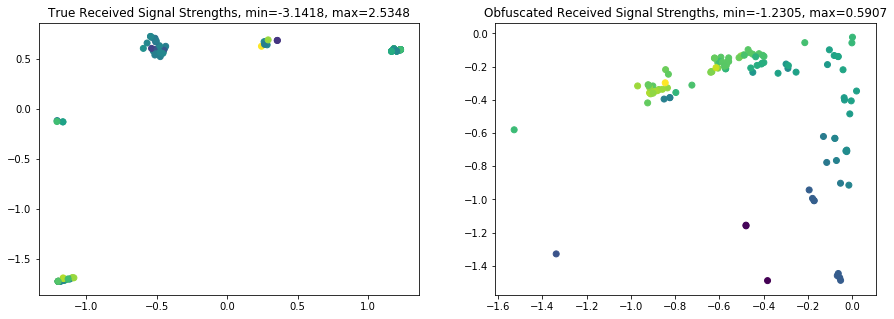

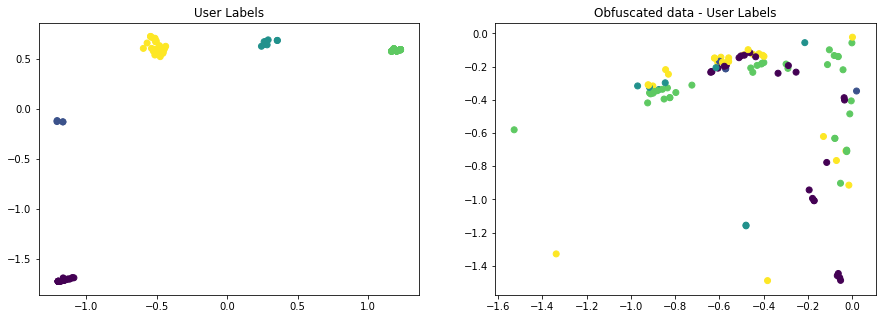

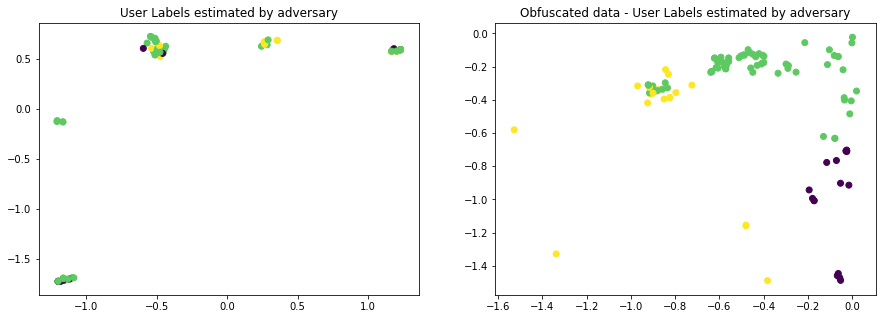

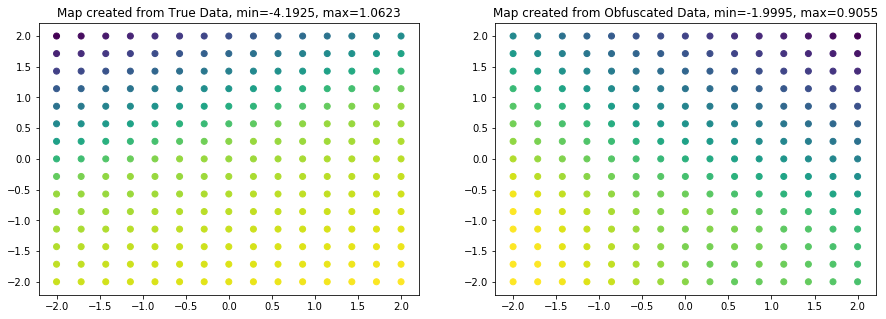

In [71]:
priv_nlayers = 2
priv_nunits = 8
ad_nlayers = 2
ad_nunits = 8

map_nlayers = 2
map_nunits = 4
map_epochs = 200
# 10 steps per epoch
samplesize = 100

penalty_value = 5
threshold_value = 0.0001
n_iterations = 100

privscope = "priv"+str(scope_iter)
adscope = "ad"+str(scope_iter)

print(scope_iter)
train_GAP(privscope, adscope, priv_nlayers, priv_nunits, ad_nlayers, ad_nunits, map_nlayers, map_nunits, map_epochs, penalty_value, threshold_value, samplesize, n_iterations)

scope_iter += 1

## Training hyperparameters for map creation (in isolation)

In [56]:
# build model from input
map_nlayers = 8
map_nunits = 13
map_epochs = 100
steps = 10
samplesize = 1000

f = open(("train_GAP/MAP"+str((map_nlayers, map_nunits, map_epochs, steps, samplesize))+".txt"), "w")
f.write("%d layers with %d units in the map model\n"%(map_nlayers, map_nunits))
f.write("trained for %d epochs with %d steps per epoch\n"%(map_epochs, steps))
f.write("train on %d samples\n"%(samplesize))
f.write("np.random.seed(0)\n\n")

x, trueusers = sampleChania(Chania, samplesize)

inputmodel = keras.Sequential()
inputmodel.add(keras.layers.Dense(map_nunits, input_shape=(2, ), activation=tf.nn.relu))
for l in range(map_nlayers-1):
    inputmodel.add(keras.layers.Dense(map_nunits, activation=tf.nn.relu))
inputmodel.add(keras.layers.Dense(1))
optimizer = tf.train.AdamOptimizer() #or FtrlOptimizer
inputmodel.compile(loss='mse', optimizer=optimizer)

class LossHistory(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        f.write("Epoch: %d\t Loss: %.4f\n"%(epoch, logs.get('loss')))
history = LossHistory()
inputmodel.fit(x[:,2:], x[:,1], steps_per_epoch=steps, epochs=map_epochs, verbose=1, callbacks=[keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00001), history])

f.close()
os.system("printf '\a'")

Epoch 1/100
100/100 [==============================] - 6s 61ms/step - loss: 0.8664
Epoch 2/100
100/100 [==============================] - 0s 5ms/step - loss: 0.6767
Epoch 3/100
100/100 [==============================] - 0s 5ms/step - loss: 0.6696
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6608
Epoch 5/100
100/100 [==============================] - 0s 5ms/step - loss: 0.6422
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6217
Epoch 7/100
100/100 [==============================] - 0s 5ms/step - loss: 0.6120
Epoch 8/100
100/100 [==============================] - 0s 5ms/step - loss: 0.6045
Epoch 9/100
100/100 [==============================] - 0s 5ms/step - loss: 0.6017
Epoch 10/100
100/100 [==============================] - 0s 5ms/step - loss: 0.6007
Epoch 11/100
100/100 [==============================] - 0s 5ms/step - loss: 0.5995
Epoch 12/100
100/100 [==============================] - 0s 5ms/step - loss: 0.5990
Epoch 13/100

0